# [실습2] 이미지 변환에 특화된 GAN 모델

### 학습목표
1. 이미지 변환에 특화된 GAN 모델의 특징을 학습합니다.

2. pix2pix와 CycleGAN의 구조를 이해합니다.

## 목차
1. pix2pix
2. CycleGAN

## 1. pix2pix

[pix2pix](https://arxiv.org/abs/1611.07004)는 2017년에 **Image-to-Image Translation with Conditional Adversarial Networks**논문에서 발표한 모델입니다. 이름에서 알 수 있듯이 cGAN을 발전시킨 모델로, 기존에는 무작위 노이즈를 입력받아 이미지를 생성했다면 pix2pix는 **이미지**를 입력받습니다. 특정한 입력 이미지와 그에 대응하는 목표 이미지를 학습하여 다양한 이미지 변환 작업을 수행합니다. 이 때 중요한 점은 입력 이미지와 목표 이미지가 **한 쌍**을 이루어야 한다는 점입니다.

pix2pix는 흑백 이미지를 컬러 이미지로 바꾸거나(`BW to Color`) 테두리만 있는 이미지를 적절하게 채색(`Edges to Photo`)하는 등 이미지 변환이 가능합니다. 

<center><img src="img/pix2pix.jpg" style="width: 800px"></center>

In [1]:
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.io import read_file, decode_jpeg
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    Conv2DTranspose,
    Dropout,
    ReLU,
    Concatenate,
    ZeroPadding2D,
)

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

### 1.1 데이터 세트 불러오기

사용하는 데이터는 **facades** 데이터 세트입니다. pix2pix 모델에서 주로 사용하는 데이터 세트는 [여기](https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)에서 확인할 수 있습니다. 도시 사진, 가방 테두리 이미지, 지도 이미지 등 학습에 필요한 데이터를 사용하거나 다운로드 받을 수 있습니다. facade 데이터 세트는 그 중 크기가 가장 작은 데이터 세트입니다.

이번 실습에서 변환하고자 하는 것은 세그멘테이션 이미지를 실제 건물 사진처럼 변환(`Labels to Facade`)하는 것입니다.

In [2]:
_URL = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz"

path_to_zip = utils.get_file(fname="facades.tar.gz", origin=_URL, extract=True)

path_to_zip = pathlib.Path(path_to_zip)

PATH = os.path.join(os.path.dirname(path_to_zip), "facades")

30168306/30168306 ━━━━━━━━━━━━━━━━━━━━ 32s 1us/step


**facades**데이터는 256 X 256 크기의 이미지 2개가 연결된 형태(256 X 512)입니다. **facades**데이터를 하나만 확인해볼까요?

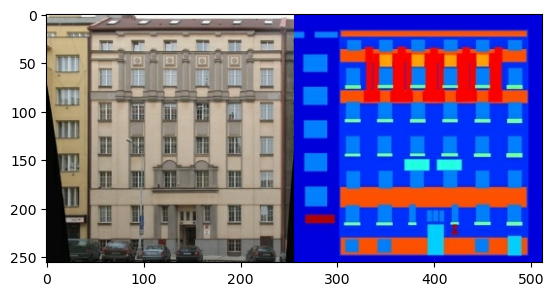

In [6]:
sample_image = read_file(os.path.join(PATH, r"C:\Users\admin\.keras\datasets\facades_extracted\facades\test/1.jpg"))
sample_image = decode_jpeg(sample_image)

plt.figure()
plt.imshow(sample_image)

모델 학습을 위해서 건물 사진과 세그멘테이션 이미지를 분리하는 과정이 필요합니다.

In [7]:
# 이미지를 불러와 텐서로 변환하고 두 개로 분리합니다.
def load(image_file):
    # 이미지를 불러와 텐서로 변환합니다.
    image = read_file(image_file)
    image = decode_jpeg(image)

    # 텐서를 두 개로 분리합니다.
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]  # 세그멘테이션 이미지
    real_image = image[:, :w, :]  # 실제 건물 사진

    # 모델 학습에 적합한 형태인 float32 형식의 텐서로 변환합니다.
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

분리한 이미지를 확인해 봅시다.

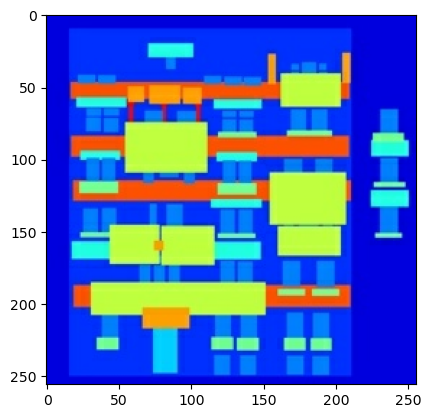

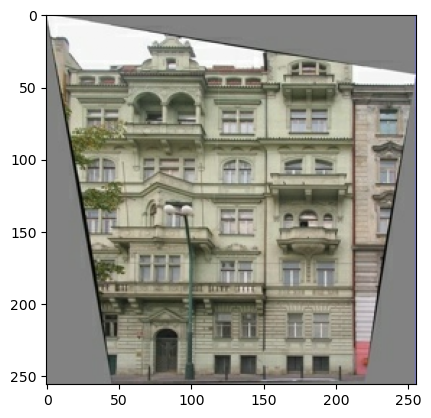

In [8]:
input_image, real_image = load(os.path.join(PATH, r"C:\Users\admin\.keras\datasets\facades_extracted\facades\train/100.jpg"))

plt.figure()
plt.imshow(input_image / 255.0)
plt.figure()
plt.imshow(real_image / 255.0)

하나였던 이미지가 두 개로 잘 분리된 모습을 확인할 수 있습니다.

pix2pix 모델의 학습을 위해 몇 가지 전처리 과정이 더 필요합니다.
1. `resize` : 256 X 256 이미지를 286 X 286로 조정
2. `random_crop` : 무작위로 다시 256 X 256으로 크롭
3. `random_mirroring` : 이미지를 가로로 무작위로 미러링
4. `normalize` : 이미지를 [-1, 1] 범위로 정규화

In [9]:
# 400개의 이미지를 학습에 사용합니다.
BUFFER_SIZE = 400
# pix2pix는 BATCH_SIZE가 1일 때 U-Net이 더 좋은 결과를 보였습니다.
BATCH_SIZE = 1
# 이미지의 크기를 256 X 256으로 설정합니다.
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [10]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    return input_image, real_image

In [11]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3]
    )

    return cropped_image[0], cropped_image[1]

In [12]:
def random_mirroring(input_image, real_image) :
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
    
    return input_image, real_image

In [13]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [14]:
# 이미지 전처리
@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)

    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        random_mirroring(input_image, real_image)

    return input_image, real_image

전처리한 이미지를 확인해 봅시다.

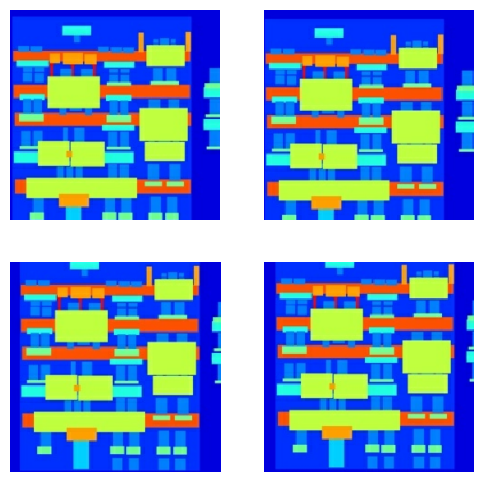

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(input_image, real_image)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis("off")
plt.show()

pix2pix 모델 학습에 적합하도록 전처리하는 과정을 모두 구현했으니 이제 학습 데이터와 훈련 데이터를 불러오겠습니다.

In [16]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [17]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [19]:
train_dataset = tf.data.Dataset.list_files(os.path.join(PATH, r"C:\Users\admin\.keras\datasets\facades_extracted\facades\train/*.jpg"))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(os.path.join(PATH, r"C:\Users\admin\.keras\datasets\facades_extracted\facades\train/*.jpg"))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### 1.2 생성자

pix2pix 모델의 생성자는 [U-Net](https://arxiv.org/abs/1505.04597) 기반 네트워크입니다. U-Net은 인코더(`다운샘플러`)와 디코더(`업샘플러`)로 구성됩니다. 
- `인코더`
    - Convolution Layer
    - Batch Normalization
    - LeakyReLU
- `디코더`
    - Convolution 2D Transpose Layer
    - Batch Normalizaion
    - Dropout
    - ReLU
- `인코더`와 `디코더` 사이에는 **Skip Connection**이 있습니다. 이 **Skip Connection**는 인코더에서 이미지의 각 단계가 디코더의 대응하는 단계에 직접 연결되게 하여(아래 이미지의 점선) 디코더에서 이미지를 디코딩 할 때 이미지의 특징을 잘 복원할 수 있도록 도와줍니다. 

<center><img src="img/pix2pix_UNet.png" style="width: 800px"></center>

#### 1.2.1 인코더(다운샘플링)

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result

#### 1.2.2 디코터(업샘플링)

In [22]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

#### 1.2.3 생성자 (인코더 + 디코더)

In [23]:
def Generator():
    inputs = Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),   # (batch_size, 128, 128, 64)
        downsample(128, 4),                         # (batch_size, 64, 64, 128)
        downsample(256, 4),                         # (batch_size, 32, 32, 256)
        downsample(512, 4),                         # (batch_size, 16, 16, 512)
        downsample(512, 4),                         # (batch_size, 8, 8, 512)
        downsample(512, 4),                         # (batch_size, 4, 4, 512)
        downsample(512, 4),                         # (batch_size, 2, 2, 512)
        downsample(512, 4),                         # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),       # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),       # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),       # (batch_size, 8, 8, 1024)
        upsample(512, 4),                           # (batch_size, 16, 16, 1024)
        upsample(256, 4),                           # (batch_size, 32, 32, 512)
        upsample(128, 4),                           # (batch_size, 64, 64, 256)
        upsample(64, 4),                            # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )  # (batch_size, 256, 256, 3)

    x = inputs

    # 인코딩
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # 디코딩
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

한번 학습되지 않은 생성자로 이미지를 생성해 볼까요?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


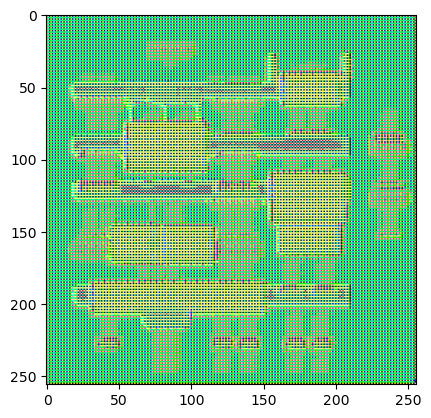

In [24]:
generator = Generator()
gen_output = generator(input_image[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### 1.3 판별자



pix2pix 모델의 판별자는 아래와 같은 구조입니다.

- **레이어 구조**
    - Convolution Layer
    - Batch Normalization
    - LeakyReLU
- **출력 형태** : (batch_size, 30, 30, 1)
    

In [25]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)

    inp = Input(shape=[256, 256, 3], name="input_image")
    tar = Input(shape=[256, 256, 3], name="target_image")

    x = Concatenate()([inp, tar])     # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)             # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)               # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)               # (batch_size, 32, 32, 256)

    zero_pad1 = ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = Conv2D(
        512, 4, strides=1, kernel_initializer=initializer, use_bias=False
    )(
        zero_pad1
    )  # (batch_size, 31, 31, 512)
    
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(
        zero_pad2
    )  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

판별자의 출력을 살펴보겠습니다.

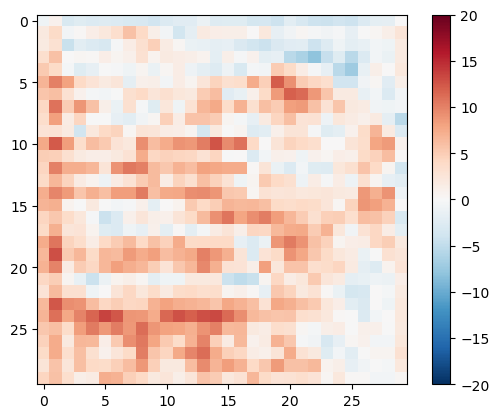

In [26]:
discriminator = Discriminator()

disc_out = discriminator([input_image[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()

### 1.4 손실함수와 옵티마이저

pix2pix 모델의 손실은 cGAN과 유사하게 **이미지를 실제와 비슷하게 생성했는지**와 **label에 맞는 이미지를 생성했는지**를 살펴봅니다. 논문에서 사용하는 손실함수는 L1과 Sigmoid Cross Entropy입니다.
- 생성자 : `L1`
- 판별자 : `Sigmoid Cross Entropy`

In [27]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # L1
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(
        tf.zeros_like(disc_generated_output), disc_generated_output
    )

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### 1.5 체크포인트 설정

모델 학습이 진행될 때 epoch별로 모델 가중치와 옵티마이저 상태를 저장하고 싶다면 체크포인트를 사용해야 합니다. 이 체크포인트를 통해 학습이 중단되었을 때 그 상태를 이어서 학습하거나, 최적의 가중치를 저장하거나, 여러 모델이 있는 경우 각 모델에 대한 가중치를 따로 관리하는 등의 용도로 활용할 수 있습니다.

In [31]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

### 1.6 학습

이제 본격적으로 pix2pix 모델을 학습시켜보도록 하겠습니다.

In [32]:
@tf.function
def train_step_pix2pix(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target
        )
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

In [33]:
# 훈련된 모델의 생성 결과를 출력합니다.
def generate_images_pix2pix(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.show()

In [34]:
def train_pix2pix(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f"Time taken for 1000 steps: {time.time()-start:.2f} sec\n")

            start = time.time()

            generate_images_pix2pix(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step_pix2pix(input_image, target, step)

        # 10개의 step이 진행될 때마다 점(.)을 출력합니다.
        if (step + 1) % 10 == 0:
            print(".", end="", flush=True)

        # 5000개의 step이 진행될 때마다 체크포인트를 저장합니다.
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

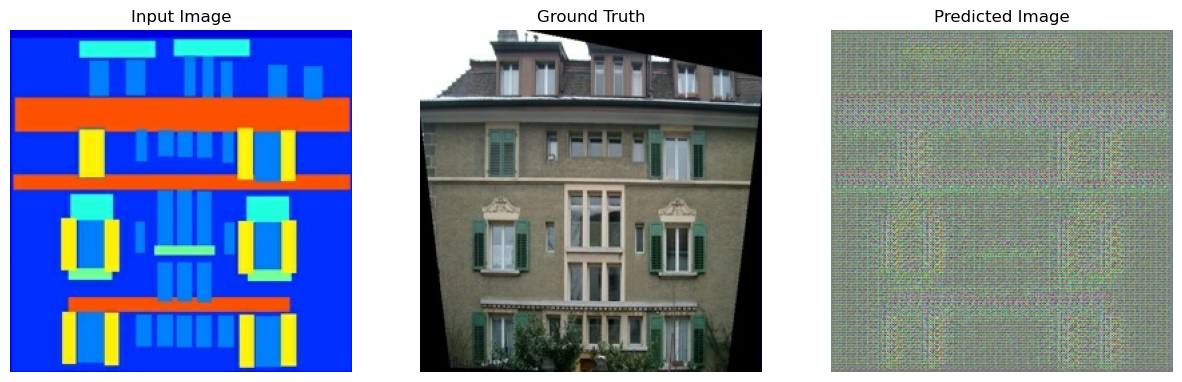

Step: 0k
....

KeyboardInterrupt: 

In [35]:
train_pix2pix(train_dataset, test_dataset, steps=10000)

학습된 모델로 테스트를 진행해 봅시다. `load_test_dataset`으로 불러온 테스트 데이터를 사용해 볼까요?

In [ ]:
for inp, tar in test_dataset.take(5):
    generate_images_pix2pix(generator, inp, tar)

출력 결과가 꽤 실제 데이터 (Ground Truth)와 유사한 것을 확인할 수 있습니다.

하지만 pix2pix의 단점은 `(실제 이미지, 타겟 이미지)`와 같이 **한 쌍의 데이터**가 필요하다는 점입니다. 풍경 사진을 피카소의 화풍이나 모네의 화풍으로 변환하고자 할 때 `(풍경 사진, 같은 풍경의 피카소 화풍 그림)`의 형태인 데이터 세트를 만든다는 것은 현실적으로 어렵습니다. 이러한 문제점을 해결한 모델을 살펴봅시다.

## 2. CycleGAN

[CycleGAN](https://arxiv.org/abs/1703.10593)는 2017년에 **Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks**논문에서 발표한 모델입니다. 위에서 진행한 pix2pix와 동일하게 cGAN을 발전시킨 모델로, pix2pix는 **쌍으로 이루어진 이미지 데이터**를 입력받았다면 CycleGAN은 **쌍으로 이루어지지 않은 이미지 데이터**를 입력받습니다.

위의 예시로 설명하자면 CycleGAN은 모델에 **풍경 사진**과 **피카소 화풍의 그림**을 쌍을 이루지 않고 학습시키면 **피카소 화풍의 풍경 이미지**를 생성할 수 있습니다. 또한 CycleGAN은 생성자와 판별자가 순환 구조를 띄고 있기 때문에 다시 피카소 화풍의 그림을 풍경 사진으로 변환할 수 있습니다. (이러한 특징 때문에 **Cycle**GAN으로 불립니다.)

<center><img src="img/CycleGAN.png" style="width: 800px"></center>

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [38]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

AUTOTUNE = tf.data.AUTOTUNE

### 2.1 데이터 세트 불러오기

이번 실습에서는 말의 이미지와 얼룩말의 이미지를 학습 데이터로 사용하겠습니다. 더 다양한 데이터 세트를 사용하고 싶다면 [여기](https://www.tensorflow.org/datasets/catalog/cycle_gan)를 참고하세요. 말과 얼룩말 이미지 외에도 여름 풍경과 겨울 풍경, 모네풍 그림과 풍경 사진같은 CycleGAN에서 사용하기 좋은 데이터 세트를 확인할 수 있습니다.

In [39]:
dataset, metadata = tfds.load(
    "cycle_gan/horse2zebra", with_info=True, as_supervised=True
)

train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\admin\tensorflow_datasets\cycle_gan\horse2zebra\incomplete.9M03RO_3.0.0\cycle_gan-trainA.tf…

Generating trainB examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\admin\tensorflow_datasets\cycle_gan\horse2zebra\incomplete.9M03RO_3.0.0\cycle_gan-trainB.tf…

Generating testA examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\admin\tensorflow_datasets\cycle_gan\horse2zebra\incomplete.9M03RO_3.0.0\cycle_gan-testA.tfr…

Generating testB examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\admin\tensorflow_datasets\cycle_gan\horse2zebra\incomplete.9M03RO_3.0.0\cycle_gan-testB.tfr…

Dataset cycle_gan downloaded and prepared to C:\Users\admin\tensorflow_datasets\cycle_gan\horse2zebra\3.0.0. Subsequent calls will reuse this data.


아래의 함수는 이미지 전처리에 사용하는 함수입니다. pix2pix에서 사용했던 `random_crop`, `random_jitter`, `normalize`함수와 유사한 형태이지만 입력 이미지가 한 쌍일 필요가 없기 때문에 하나의 이미지만 입력받도록 수정합니다.

In [ ]:
# 1000개의 이미지를 학습에 사용합니다.
BUFFER_SIZE = 1000
# pix2pix는 BATCH_SIZE가 1일 때 U-Net이 더 좋은 결과를 보였습니다.
BATCH_SIZE = 1
# 이미지의 크기를 256 X 256으로 설정합니다.
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

In [ ]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [ ]:
def random_jitter(image):
    # 이미지 사이즈 조정
    image = tf.image.resize(
        image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )

    # 이미지 크롭
    image = random_crop(image)

    # 이미지 미러링
    image = tf.image.random_flip_left_right(image)

    return image

In [ ]:
# 학습 데이터를 전처리합니다.
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)
    return image

In [ ]:
# 테스트 데이터를 전처리합니다.
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

위에서 구현한 전처리 함수를 사용해서 말과 얼룩말 이미지를 학습 데이터와 테스트 데이터로 분리하여 불러오겠습니다.

In [ ]:
train_horses = (
    train_horses.cache()
    .map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

train_zebras = (
    train_zebras.cache()
    .map(preprocess_image_train, num_parallel_calls=AUTOTUNE)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

test_horses = (
    test_horses.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

test_zebras = (
    test_zebras.map(preprocess_image_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

불러온 이미지를 확인해 볼까요?

In [ ]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

In [ ]:
plt.subplot(121)
plt.title("Horse")
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Horse with random jitter")
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

In [ ]:
plt.subplot(121)
plt.title("Zebra")
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Zebra with random jitter")
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

### 2.2 생성자와 판별자

CycleGAN의 생성자와 판별자는 pix2pix와 유사합니다. 차이점은 아래와 같습니다.
- `Instance Normalization` : Batch Normalization 대신 Instance Normalization을 사용합니다.
    - 이미지의 각 인스턴스에 대해 독립적으로 수행되어 배치 사이즈에 영향을 받지 않으며 주어진 이미지에 스타일이 고정될 수 있습니다.
- `ResNet` : U-Net 대신 ResNet을 사용합니다.
    - 단, 현재 실습에서는 단순화를 위해 U-Net을 사용합니다.
- `2개의 생성자와 판별자` : CycleGAN은 순환구조를 위해 2개의 생성자(`G`, `F`)와 2개의 판별자(`D_X`, `D_Y`)로 구성되어 있습니다.
    - 생성자 `G` : 도메인이 X인 이미지를 도메인 Y로 변환
    - 생성자 `F` : 도메인이 Y인 이미지를 도메인 X로 변환
    - 판별자 `D_X` : 실제 도메인이 X인 이미지와 생성된 도메인 X 이미지(`F(Y)`)를 판별
    - 판별자 `D_Y` : 실제 도메인이 Y인 이미지와 생성된 도메인 Y 이미지(`F(X)`)를 판별

<center><img src="img/CycleGAN_Structure.png" style="width: 1000px"></center>

pix2pix에서 사용한 생성자와 판별자를 불러오고 CycleGAN에 맞게 구조를 변경합니다.

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target=False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target=False)

학습하지 않은 CycleGAN 모델을 사용해서 이미지를 생성합니다.

In [ ]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ["Horse", "To Zebra", "Zebra", "To Horse"]

for i in range(len(imgs)):
    plt.subplot(2, 2, i + 1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

생성된 이미지는 아직까진 노이즈처럼 보입니다. 학습을 진행하여 결과를 확인해 봅시다.

### 2.3 손실함수와 옵티마이저

손실함수와 옵티마이저 역시 pix2pix와 유사합니다.

In [ ]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

CycleGAN에는 학습 데이터가 쌍을 이루고 있지 않기 때문에 입력된 두 이미지가 서로에게 의미 있다는 보장이 없습니다. 따라서 네트워크가 올바른 매핑을 학습하도록 강제하기 위해 논문에서는 `Cycle Consistency Loss`를 제안합니다.

`Cycle Consistency Loss`란 도메인 X의 이미지를 도메인 Y의 이미지로 변환(`G(X)`)한 다음, 다시 도메인 X로 변환(`F(G(X))`)했을 때 원래의 이미지와 유사해야 한다는 것을 의미합니다. 즉, X와 F(G(X)) 사이의 평균 절대 오차(MAE)를 구해 손실함수에 추가해야 합니다.

$$L_{cycle} = ||G(F(Y)) - Y|| + ||F(G(X)) - X||$$

In [ ]:
# 추가한 손실함수 (Cycle Consistency Loss)
def cycle_consistency_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

또 추가한 손실함수로 `Identity Loss`가 있습니다.

도메인 Y의 이미지를 생성자 `G`(도메인 X를 도메인 Y로 변환)에 입력했을 때 입력 이미지와 크게 다르지 않아야 합니다. 이미 입력한 이미지가 변환하고자 하는 스타일이기 때문입니다. 

$$ L_{identity} = ||G(Y) - Y|| + ||F(X) - X|| $$

In [ ]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

생성자와 판별자의 옵티마이저를 설정합니다.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### 2.4 체크포인트 설정

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    generator_g=generator_g,
    generator_f=generator_f,
    discriminator_x=discriminator_x,
    discriminator_y=discriminator_y,
    generator_g_optimizer=generator_g_optimizer,
    generator_f_optimizer=generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer,
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

### 2.5 학습

논문에서는 200 epoch로 학습을 진행했습니다. 하지만 현재 실습 환경에서는 너무 오래 걸리기 때문에 epoch를 10으로 설정하겠습니다.

In [ ]:
EPOCHS = 10

In [ ]:
def generate_images_cycle(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ["Input Image", "Predicted Image"]

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.show()

In [ ]:
@tf.function
def train_step_cycle(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:

        # G(X)와 F(G(X)) 생성
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # F(Y)와 G(F(Y)) 생성
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity Loss를 구하기 위해 G(Y)와 F(X) 생성
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # 손실값 계산
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = (
            cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)
        )

        # 생성자의 손실값
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # 생성자와 판별자의 그래디언트를 구합니다.
    generator_g_gradients = tape.gradient(
        total_gen_g_loss, generator_g.trainable_variables
    )
    generator_f_gradients = tape.gradient(
        total_gen_f_loss, generator_f.trainable_variables
    )

    discriminator_x_gradients = tape.gradient(
        disc_x_loss, discriminator_x.trainable_variables
    )
    discriminator_y_gradients = tape.gradient(
        disc_y_loss, discriminator_y.trainable_variables
    )

    # 그래디언트를 옵티마이저에 적용합니다.
    generator_g_optimizer.apply_gradients(
        zip(generator_g_gradients, generator_g.trainable_variables)
    )

    generator_f_optimizer.apply_gradients(
        zip(generator_f_gradients, generator_f.trainable_variables)
    )

    discriminator_x_optimizer.apply_gradients(
        zip(discriminator_x_gradients, discriminator_x.trainable_variables)
    )

    discriminator_y_optimizer.apply_gradients(
        zip(discriminator_y_gradients, discriminator_y.trainable_variables)
    )

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step_cycle(image_x, image_y)
        if n % 10 == 0:
            print(".", end="")
        n += 1

    display.clear_output(wait=True)
    
    generate_images_cycle(generator_g, sample_horse)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print("Saving checkpoint for epoch {} at {}".format(epoch + 1, ckpt_save_path))

    print("Time taken for epoch {} is {} sec\n".format(epoch + 1, time.time() - start))

In [ ]:
for inp in test_horses.take(5):
    generate_images_cycle(generator_g, inp)

어떤가요? 아직 완벽하진 않지만 얼추 얼룩말의 무늬가 보이는 것 같습니다. 더 많은 epoch를 진행하면 처음 CycleGAN을 소개할 때 보여드렸던 이미지와 같이 거의 완벽한 얼룩말의 이미지를 생성할 수 있습니다.

---

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>